In [296]:
import sys, joblib
sys.path.append('../../..')
from grid import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
r = joblib.load('output/output-taskgrammar-iter4-grammarpen_setloc-recog.bin')
#r = joblib.load('output/output-taskgrammar-iter4-grammarpen.bin')
#r = joblib.load('output/output-taskpeople_gibbs-iter2.bin')
result = r['result']
train = r['train']

In [122]:
train = list(tasks_from_grammar_boards())
test = train

g0 = Grammar.uniform(
    primitives,
    # when doing grid_cont instead, we only consider $0
    # but when we only have type=tgrid_cont, then we get a nicer library for tree_tasks()
    continuationType=arrow(tgrid_cont,tgrid_cont))
arguments = commandlineArguments(
    #iterations=1,
    #enumerationTimeout=1,
    #maximumFrontier=10,
    enumerationTimeout=30,
    solver='ocaml',
    compressor="ocaml",
    activation='tanh',
    iterations=3, recognitionTimeout=3600,
    # TODO what does this arity do? seems to relate to grammar?
    a=3,
    maximumFrontier=10, topK=2, pseudoCounts=30.0,
    helmholtzRatio=0.5, structurePenalty=1.,
    CPUs=1,
)

generator = ecIterator(g0, train, testingTasks=test, **arguments)
for result in generator:
    break


CUDA is available?: False
using cuda?: False


usage: ipykernel_launcher.py [-h] [--resume RESUME] [-i ITERATIONS]
                             [-t ENUMERATIONTIMEOUT] [-R RECOGNITIONTIMEOUT]
                             [-RS RECOGNITIONSTEPS] [-k TOPK] [-p PSEUDOCOUNTS]
                             [-b AIC] [-l STRUCTUREPENALTY] [-a ARITY] [-c CPUS]
                             [--no-cuda] [-m MAXIMUMFRONTIER] [--reuseRecognition]
                             [--recognition] [--ensembleSize ENSEMBLESIZE] [-g] [-d]
                             [--no-consolidation] [--testingTimeout TESTINGTIMEOUT]
                             [--testEvery TESTEVERY] [--seed SEED]
                             [--activation {relu,sigmoid,tanh}]
                             [--solver {ocaml,pypy,python}] [-r HELMHOLTZRATIO]
                             [--compressor {pypy,rust,vs,pypy_vs,ocaml,memorize}]
                             [--matrixRank MATRIXRANK] [--mask] [--biasOptimal]
                             [--contextual] [--clear-recognition CLEA

SystemExit: 2

/Users/carlos/pu/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Now rendering tasks.

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

def env_rect(grid, facecolor="none", edgecolor="k", linewidth=0.5):
    return [
        (
            s,
            plt.Rectangle((s[0]-0.5, s[1]-0.5), 1, 1, linewidth=linewidth, facecolor=facecolor, edgecolor=edgecolor),
        )
        for s in np.ndindex(grid.shape)
    ]

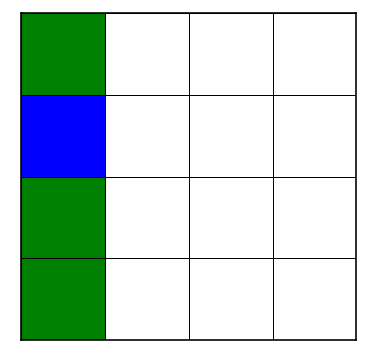

In [124]:
def showtask(start, end, history=None, *, size=3, ax=None):
    w, h = start.shape
    asp = w/h
    if ax is None:
        _, ax = plt.subplots(figsize=(size*asp, size))
    ax.set(
        xticks=[],
        yticks=[],
        xlim=[-1/2, w-1/2],
        ylim=[-1/2, h-1/2],
    )
    for xy, r in env_rect(start):
        if start[xy]:
            r.set_facecolor('blue')
        elif end[xy]:
            r.set_facecolor('green')
        ax.add_artist(r)
    if history:
        for prev, curr in zip(history[:-1], history[1:]):
            if prev['location'] == (-1, -1):
                ax.scatter(*curr['location'], marker='*')
                continue
            ax.plot(
                [prev['location'][0], curr['location'][0]],
                [prev['location'][1], curr['location'][1]],
                c='k')
task = next(tasks_from_grammar_boards())
primitives = primitives_loc
_g0 = Grammar.uniform(primitives, continuationType=arrow(tgrid_cont,tgrid_cont))
s = executeGrid(_g0.sample(_g0.continuationType), GridState(task.start, task.location, history=[]))
showtask(task.start, task.goal, s.history)

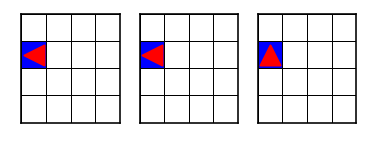

In [125]:
def show_trace(start, final_state):
    h = final_state.history

    f, axes = plt.subplots(1, len(h), figsize=(len(h), 1))
    for i, ax in enumerate(axes):
        h_so_far = h[:i+1]
        assert len(h_so_far) == i+1
        last_state = h_so_far[-1]
        showtask(start, last_state['grid'], h_so_far, ax=ax)
        #m = ['^', '>', 'v', '<'] # actually is rotate clockwise 90deg from this
        m = ['<', '^', '>', 'v'][last_state['orientation']]
        ax.scatter(*last_state['location'], c='r', zorder=2, marker=m, s=400/start.shape[0])

show_trace(task.start, s)

# showing all solutions

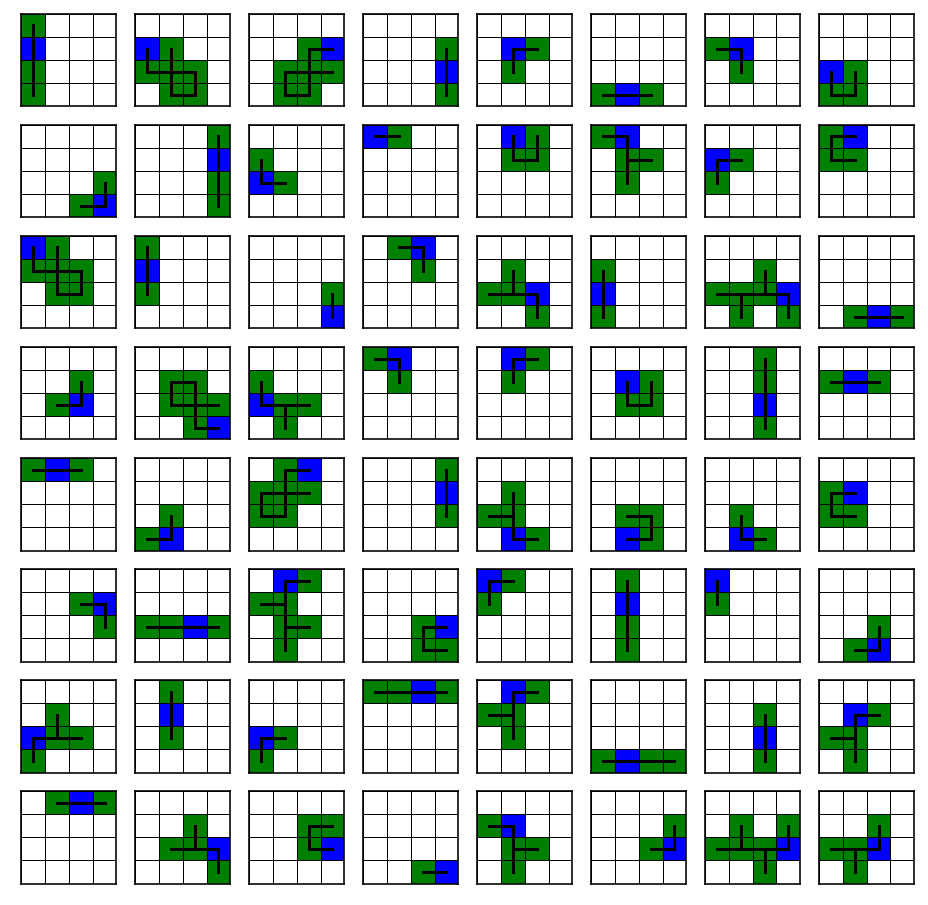

In [126]:
total = sum(1 for v in result.frontiersOverTime.values() if len(v[-1].entries))
f, axes = plt.subplots(8, 8, figsize=(8, 8))
axes = axes.flatten().tolist()

for task in train:
    es = result.frontiersOverTime[task][-1].entries
    if not es:
        continue
    fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
    s = executeGrid(fe.program, GridState(task.start, task.location, history=[]))
    assert np.all(s.grid == task.goal)
    showtask(task.start, task.goal, s.history, ax=axes.pop(0))
    if not axes:
        break

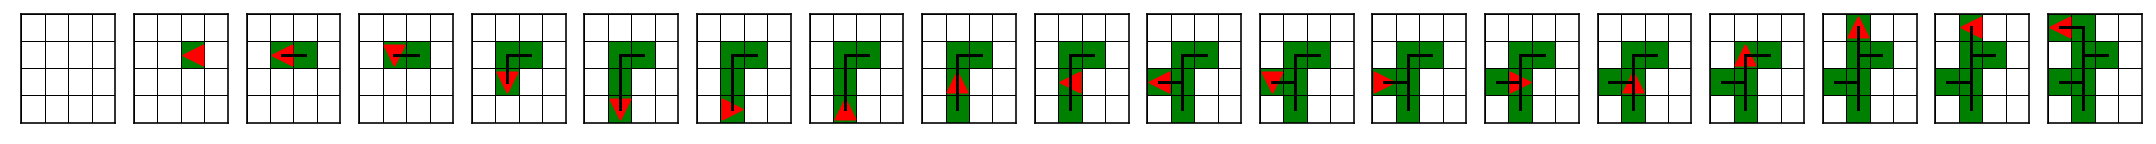

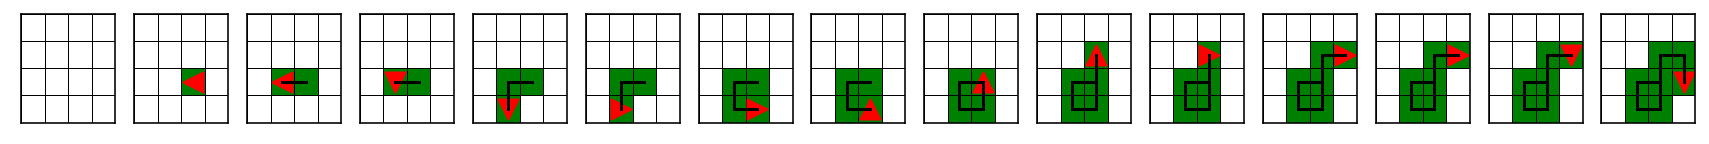

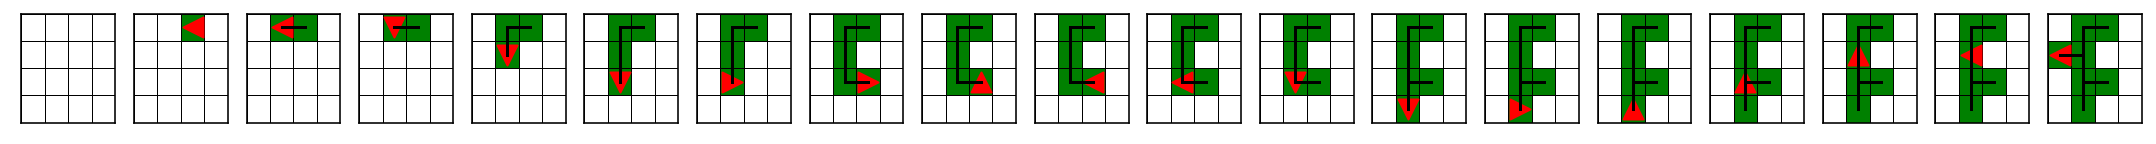

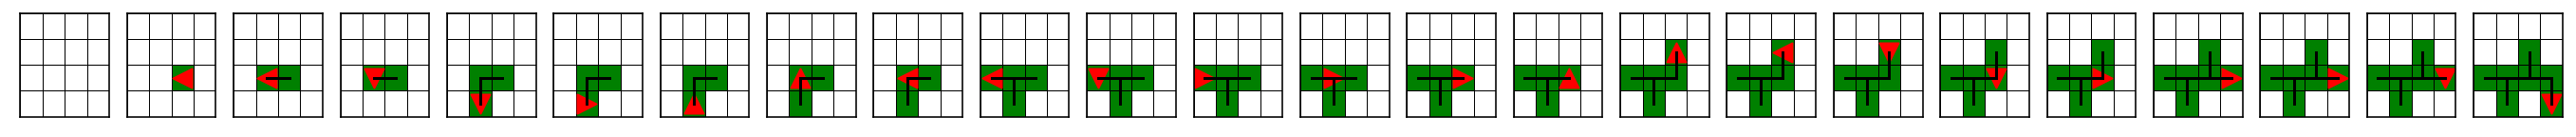

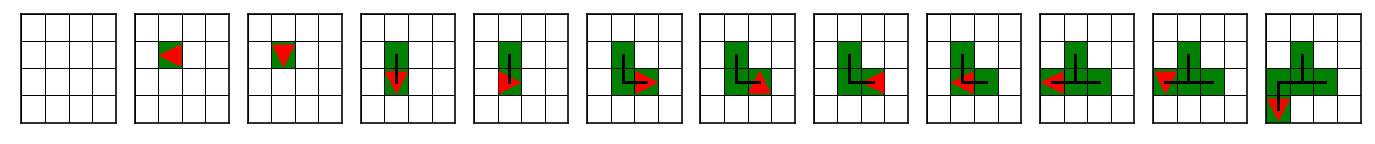

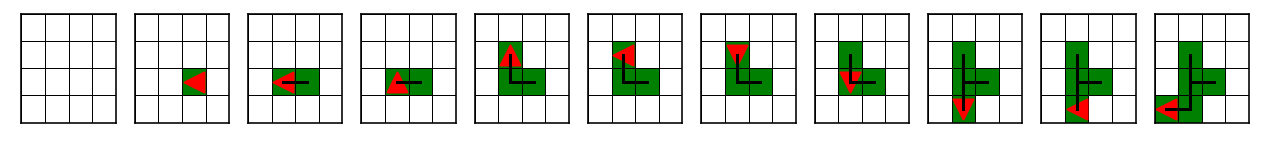

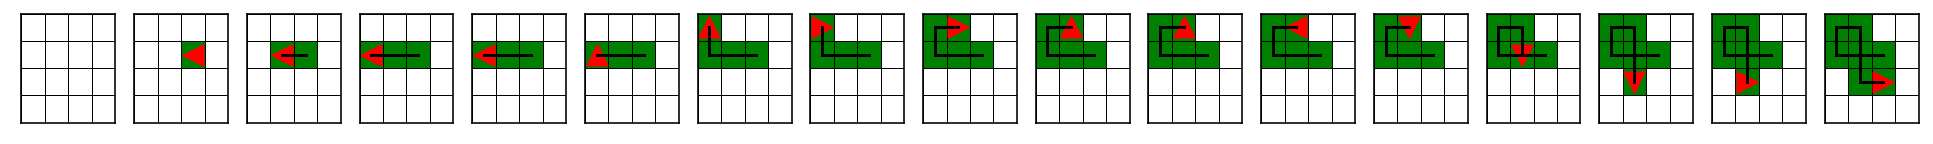

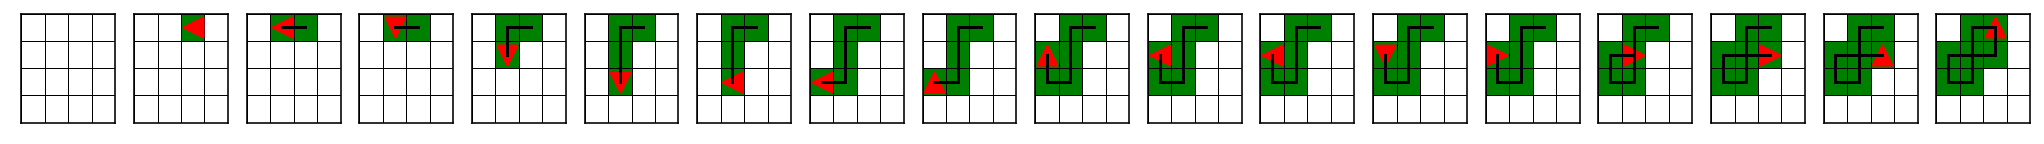

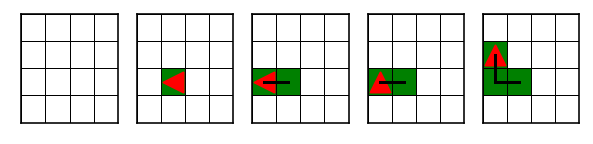

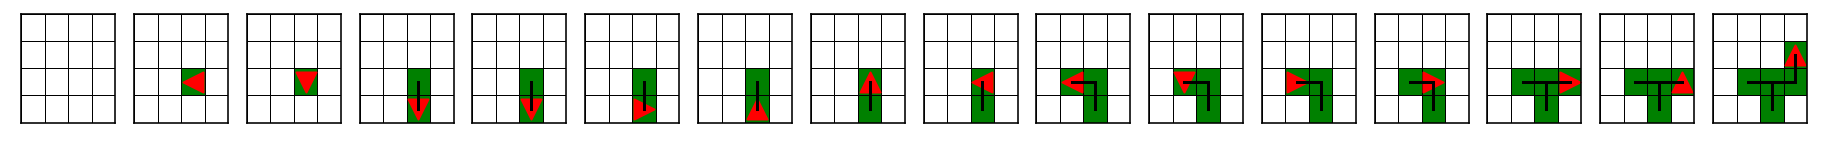

In [301]:
weights = []
for task in train:
    es = result.frontiersOverTime[task][-1].entries
    if es:
        fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
        weights.append(-fe.logPrior)
    else:
        weights.append(-float('inf'))

import random
for taskidx in np.random.choice(len(train), p=scipy.special.softmax(weights), replace=False, size=10):
    task = train[taskidx]
    es = result.frontiersOverTime[task][-1].entries
    if not es:
        continue
    fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
    s = executeGrid(fe.program, GridState(task.start, task.location, history=[]))
    assert np.all(s.grid == task.goal)
    show_trace(task.start, s)

# dreams

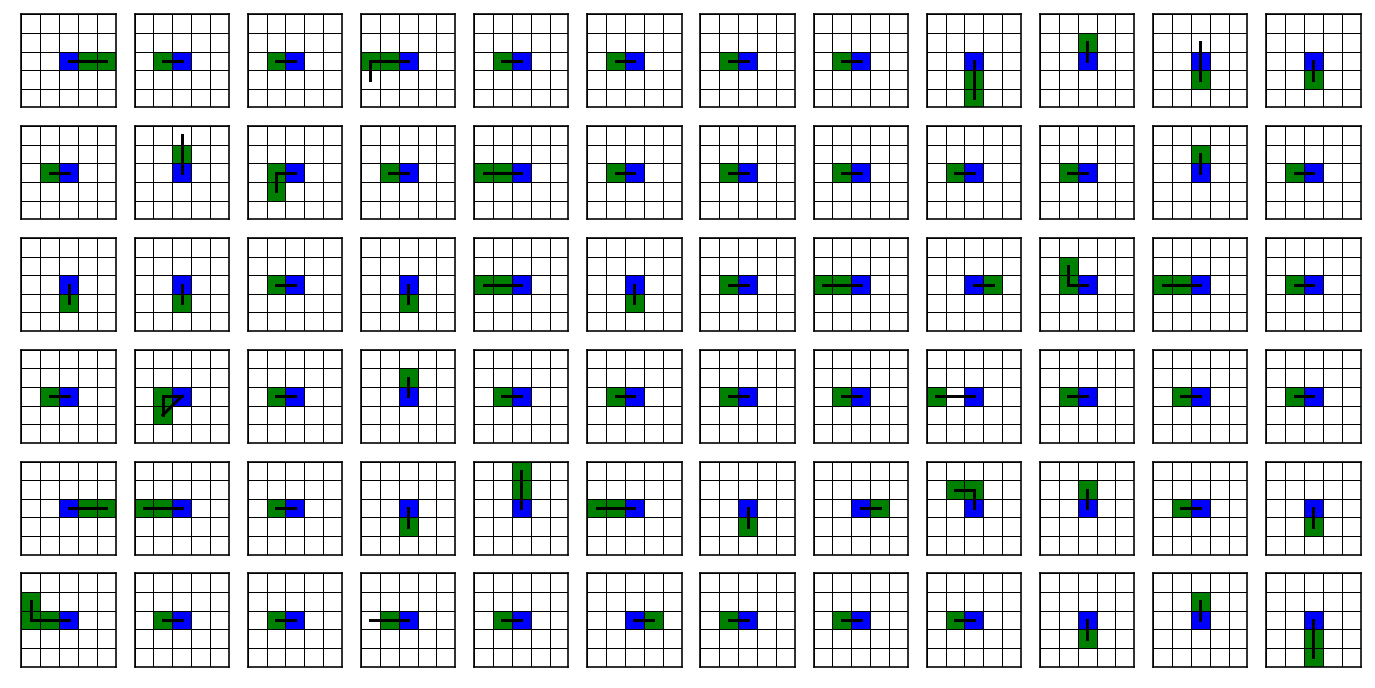

In [43]:
def dream_grammar(g):
    f, axes = plt.subplots(6, 12, figsize=(12, 6))
    axes = axes.flatten().tolist()

    #trivial = dreamcoder.program.Abstraction(dreamcoder.program.Index(0))
    programs = []

    for ax in axes:
        start, location = np.array([[0]*5]*5), (2, 2)
        start[location] = 1
        for _ in range(20):
            p = g.sample(g.continuationType)
            '''
            if p != trivial:
                break
            '''
            s = executeGrid(p, GridState(start, location, history=[]))
            if s is None:
                continue
            if not np.all(start==s.grid):
                break
        showtask(start, s.grid, s.history, ax=ax)
        programs.append(p)

dream_grammar(result.grammars[0])

In [ ]:
dream_grammar(result.grammars[1])

In [ ]:
dream_grammar(result.grammars[2])

In [ ]:
dream_grammar(result.grammars[3])

# library

In [284]:
def simplest_sorted_library(library):
    return sorted(
        library,
        # First we sort by # of references to other library items
        # then we sort by program length
        key=lambda fn: (len(str(fn).split('#')), len(str(fn))))

def distinct(idx, grammars):
    #prev = {p for g in grammars[:idx] for p in g.primitives}
    prev = {p for p in grammars[0].primitives}
    distinct = set(grammars[idx].primitives) - prev
    return simplest_sorted_library(distinct)

distinct(2, result.grammars)

[#(lambda (grid_left (grid_move $0))),
 #(lambda (grid_move (grid_right (grid_move $0)))),
 #(lambda (lambda (lambda (grid_setlocation $1 $0 (grid_move (grid_move $2)))))),
 #(lambda (lambda (lambda (grid_setlocation $2 $0 (#(lambda (grid_left (grid_move $0))) (grid_move $1)))))),
 #(lambda (lambda (lambda (grid_setlocation $2 $0 (grid_move (#(lambda (grid_left (grid_move $0))) $1)))))),
 #(lambda (#(lambda (lambda (lambda (grid_setlocation $1 $0 (grid_move (grid_move $2)))))) (grid_move $0) 3)),
 #(lambda (lambda (lambda (grid_setlocation $1 $0 (#(lambda (grid_left (grid_move $0))) (grid_right (grid_move $2))))))),
 #(lambda (lambda (lambda (grid_setlocation $2 $0 (grid_right (grid_move (#(lambda (grid_left (grid_move $0))) $1))))))),
 #(lambda (lambda (grid_setlocation $0 1 (grid_left (grid_left (#(lambda (grid_move (grid_right (grid_move $0)))) $1)))))),
 #(lambda (grid_left (#(lambda (grid_left (grid_move $0))) (#(lambda (grid_move (grid_right (grid_move $0)))) $0)))),
 #(lambda (l

In [286]:
def simplify_signature(fn, tint_value):
    '''
    Plugs in a filler int value if the library routine takes them as parameters
    '''
    rewrote = False

    rv = fn
    ret = fn.infer()

    while ret.isArrow():
        arg, ret = ret.arguments

        if arg == tint:
            rewrote = True
            rv = Application(rv, primitives_numbers_only[tint_value-1])
            '''
        elif arg.isArrow(): # this is a complete hack & will only work for grid_cont -> grid_cont
            rewrote = True
            print('arrow arg', arg, 'rv', rv.infer(), rv)
            rv = Application(rv, Abstraction(Index(0)))
            print('rewrote to', rv.infer(), rv)
            '''
        else:
            rv = Application(rv, Index(0))

    if rewrote:
        return Abstraction(rv)
    else:
        return fn


Could not execute library function with signature ((grid_cont -> grid_cont) -> grid_cont) -> int -> grid_cont


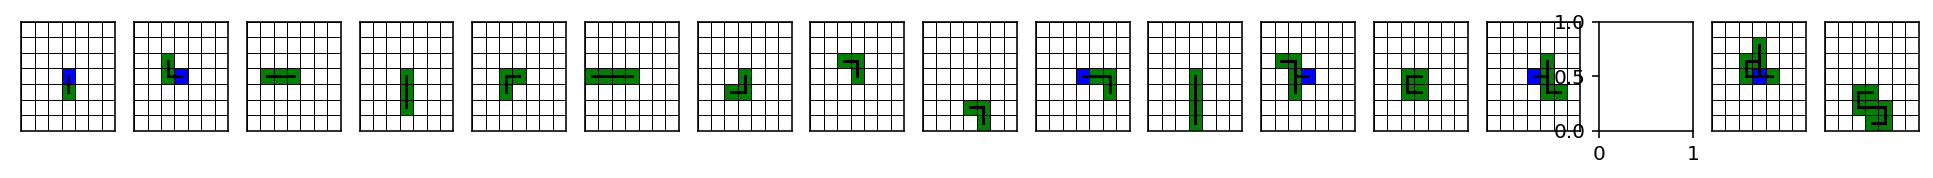

In [287]:
def exec_library_fn(fn):
    orig_fn = fn

    start, location = np.array([[0]*7]*7), (3, 3)
    fn = simplify_signature(fn, location[0])

    has_setloc = 'setloc' in str(fn) # HACK
    if has_setloc:
        # Need to do this to avoid cases where setloc is used incorrectly
        location = (-1, -1)
    else:
        start[location] = 1

    s = executeGrid(fn, GridState(start, location, history=[]))
    # HACK for some library functions, we haven't implemented a way to simplify above, so we
    # wind up with a callaback here.
    if callable(s):
        print('Could not execute library function with signature', orig_fn.infer())
        s = None
    return start, s

def visualize_functions(fns):
    if not fns:
        print('No functions')
        return

    f, axes = plt.subplots(1, len(fns), figsize=(len(fns), 1))

    for fn, ax in zip(fns, axes):
        start, s = exec_library_fn(fn)
        if s is None:
            continue
        showtask(start, s.grid, s.history, ax=ax)

visualize_functions(distinct(2, result.grammars))

library after iteration 1


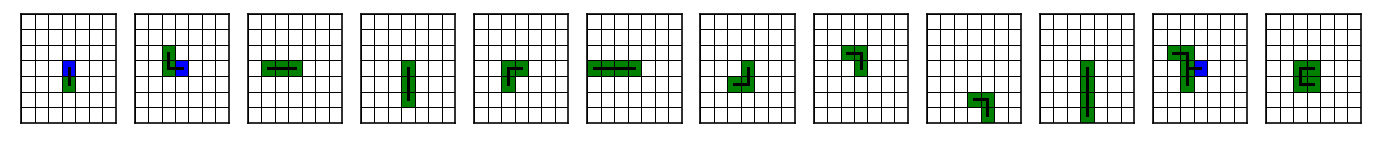

library after iteration 2
Could not execute library function with signature ((grid_cont -> grid_cont) -> grid_cont) -> int -> grid_cont


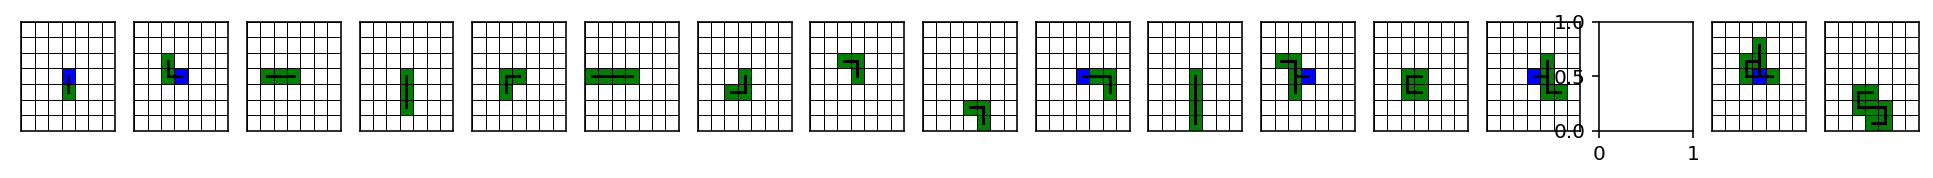

library after iteration 3
Could not execute library function with signature ((grid_cont -> grid_cont) -> grid_cont) -> int -> grid_cont


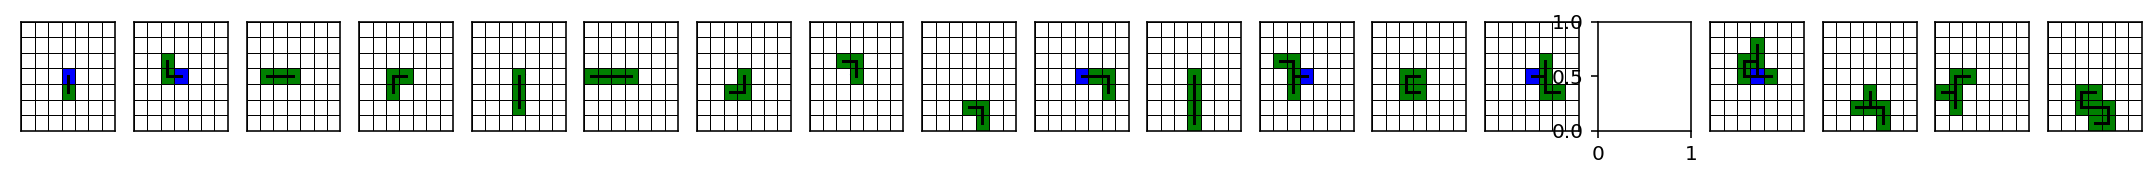

library after iteration 4
Could not execute library function with signature ((grid_cont -> grid_cont) -> grid_cont) -> int -> grid_cont


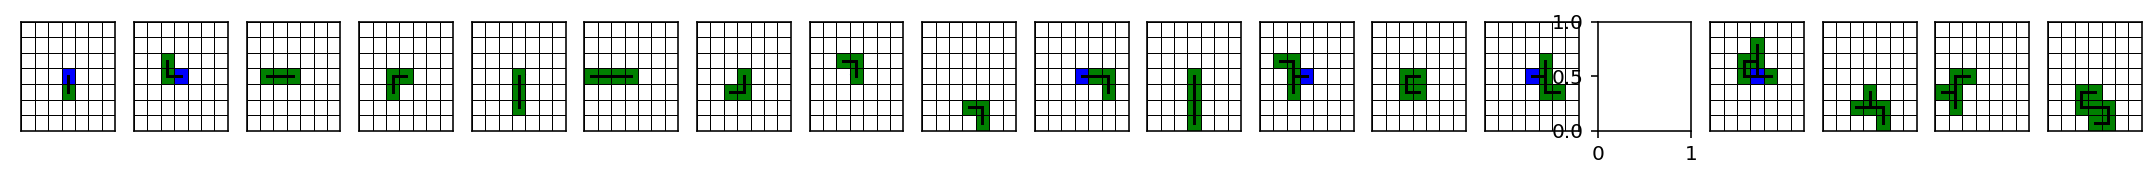

library after iteration 5
Could not execute library function with signature ((grid_cont -> grid_cont) -> grid_cont) -> int -> grid_cont


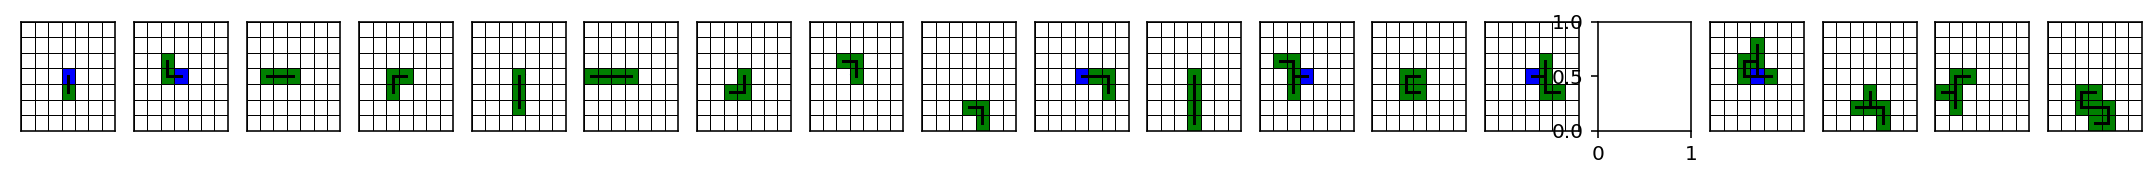

In [288]:
for i in range(1, len(result.grammars)):
    print(f'library after iteration {i}')
    visualize_functions(distinct(i, result.grammars))
    plt.show()

# visualizing traces of final library

In [289]:
items = distinct(3, result.grammars)
prog_desc_depth = simplest_sorted_library(items)
fnnames = {}
compressed = {}

def library_use_by_name(fn):
    strfn = str(fn)
    for subfn in prog_desc_depth[::-1]:
        if subfn in fnnames:
            strfn = strfn.replace(str(subfn), fnnames[subfn])
    return strfn

for i, fn in enumerate(prog_desc_depth):
    fnnames[fn] = f'FN{i}'
    compressed[fn] = library_use_by_name(fn)

In [290]:
def simple_use_of_library(p):
    '''
    Tries to identify cases where our program is just pretty directly using an abstraction.
    '''
    assert type(p) == Abstraction
    assert type(p.body) == Application
    f = p.body
    while type(f) != Invented and type(f) == Application:
        if type(f.x) not in (Primitive, Index):
            return False
        f = f.f
    return True

In [293]:
simple = []
for task in train:
    es = result.frontiersOverTime[task][-1].entries
    if not es:
        continue
    fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
    p = fe.program
    if simple_use_of_library(p):
        simple.append(library_use_by_name(p))
        continue
    print(task, library_use_by_name(p))

print(f'{len(simple)} simple programs: {" ".join(simple)}')

grammar_boards.pkl[2] (lambda (FN12 2 (FN0 (FN1 (FN1 $0))) 1))
grammar_boards.pkl[4] (lambda (FN14 (lambda $1) 2))
grammar_boards.pkl[10] (lambda (grid_setlocation 1 1 (FN1 $0)))
grammar_boards.pkl[13] (lambda (grid_setlocation 2 2 (FN11 $0)))
grammar_boards.pkl[16] (lambda (FN2 (FN15 $0) 2 2))
grammar_boards.pkl[22] (lambda (FN14 (lambda (FN13 ($0 (FN1 $1)))) 1))
grammar_boards.pkl[26] (lambda (FN17 (FN1 $0) 1))
grammar_boards.pkl[28] (lambda (FN14 (lambda $1) 3))
grammar_boards.pkl[34] (lambda (FN14 (lambda (FN15 $1)) 3))
grammar_boards.pkl[36] (lambda (FN2 (FN13 $0) 1 1))
grammar_boards.pkl[38] (lambda (FN4 1 (FN0 $0) 1))
grammar_boards.pkl[42] (lambda (FN14 (lambda (grid_move (FN0 (FN13 $1)))) 3))
grammar_boards.pkl[48] (lambda (grid_setlocation 1 2 (grid_left (FN11 $0))))
grammar_boards.pkl[60] (lambda (grid_setlocation 2 1 (FN11 $0)))
grammar_boards.pkl[62] (lambda (FN16 (FN13 $0) 1))
grammar_boards.pkl[63] (lambda (FN14 (lambda (FN13 $1)) 1))
grammar_boards.pkl[65] (lambda (FN14

FN0 FN0


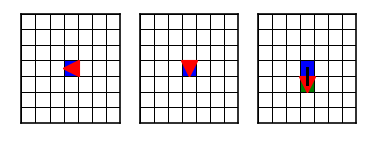

FN1 FN1


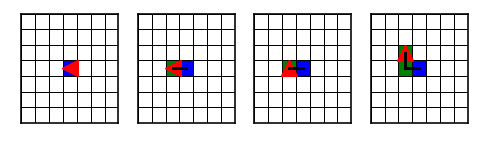

FN2 FN2


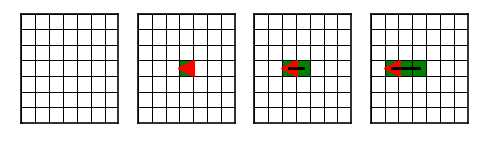

FN3 FN3


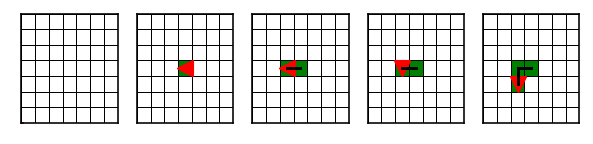

FN4 FN4


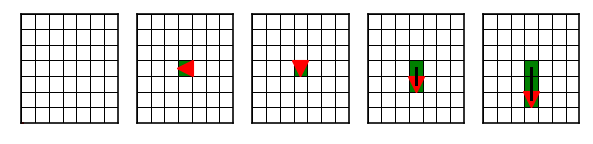

FN5 FN5


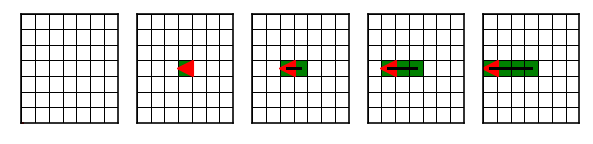

FN6 FN6


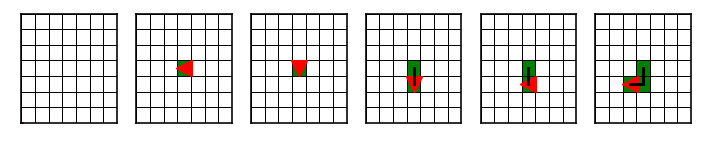

FN7 FN7


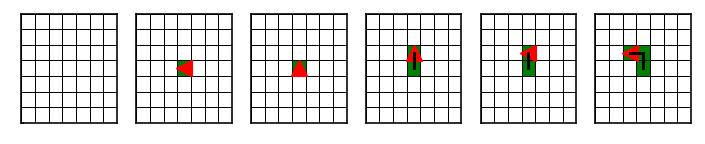

FN8 FN8


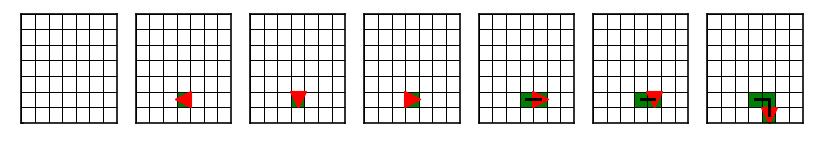

FN9 FN9


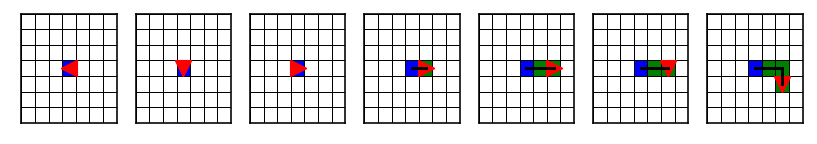

FN10 FN10


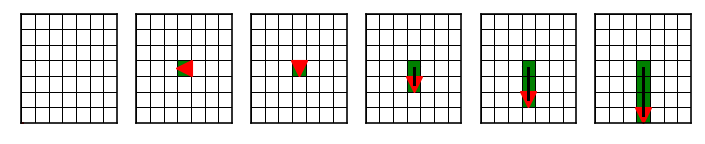

FN11 FN11


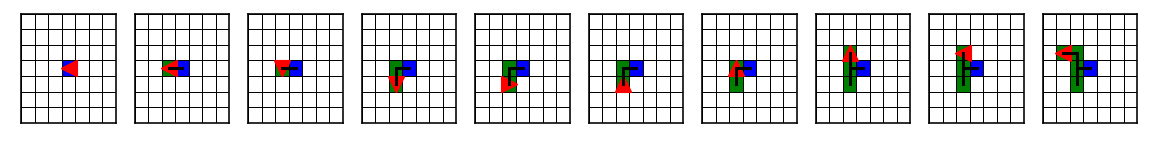

FN12 FN12


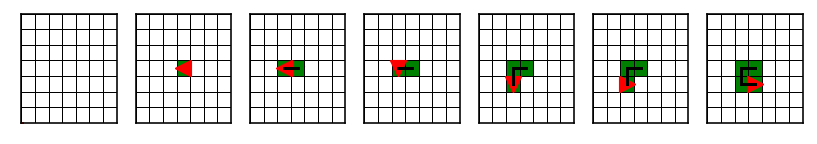

FN13 FN13


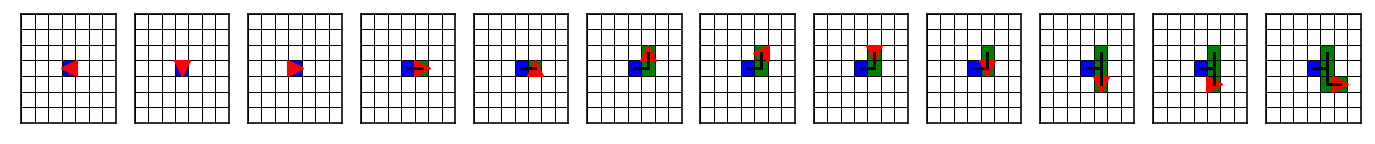

FN14 FN14
Could not execute library function with signature ((grid_cont -> grid_cont) -> grid_cont) -> int -> grid_cont
FN15 FN15


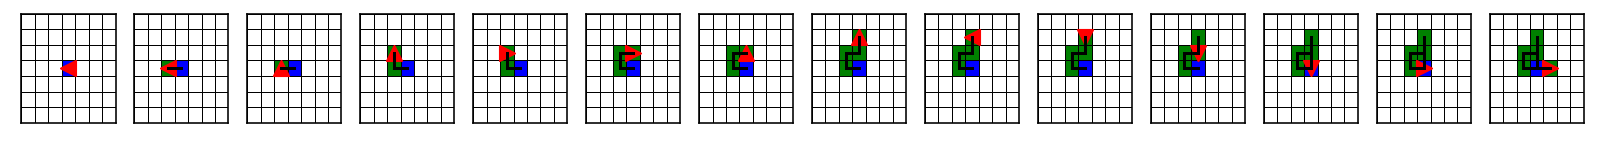

FN16 FN16


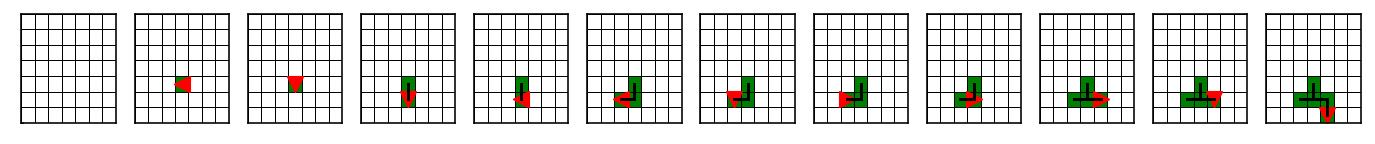

FN17 FN17


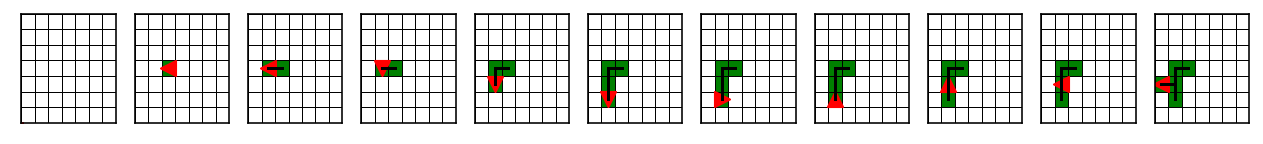

FN18 FN18


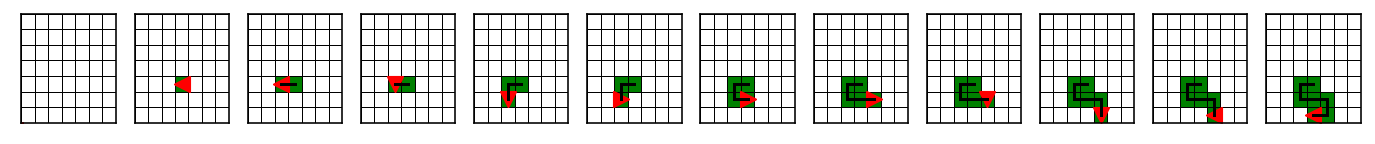

In [295]:
for fn in prog_desc_depth:
    print(fnnames[fn], compressed[fn])
    start, s = exec_library_fn(fn)
    if s is None:
        continue
    show_trace(start, s)
    plt.show()

# counting use of primitives

In [327]:
import collections
def count_primitives(p, *, ct=None):
    if ct is None:
        ct = collections.Counter()
    class Counter(object):
        def invented(self, e): e.body.visit(self)
        def primitive(self, e): ct[e]+=1
        def index(self, e): pass
        def application(self, e): e.f.visit(self); e.x.visit(self)
        def abstraction(self, e): e.body.visit(self)
    p.visit(Counter())
    return ct

def count_prim():
    for fn in [
        'output/output-taskgrammar-iter4-grammarpen.bin',
        'output/output-taskgrammar-iter4-grammarpen_setloc-recog.bin',
    ]:
        r = joblib.load(fn)
        ct = collections.Counter()
        topct = collections.Counter()
        for task in r['train']:
            es = r['result'].frontiersOverTime[task][-1].entries
            if not es:
                continue
            fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
            count_primitives(fe.program, ct=topct)
            for e in es:
                p = e.program
                count_primitives(p, ct=ct)
        print(fn)
        print('best program', topct)
        print('top5', ct)

count_prim()

output/output-taskgrammar-iter4-grammarpen.bin
best program Counter({grid_move: 229, grid_left: 100, grid_embed: 68, grid_right: 55})
top5 Counter({grid_move: 1221, grid_left: 641, grid_embed: 405, grid_right: 328, grid_dopendown: 12})
output/output-taskgrammar-iter4-grammarpen_setloc-recog.bin
best program Counter({grid_move: 252, grid_left: 160, grid_setlocation: 63, 2: 52, 1: 44, grid_right: 32, 3: 30})
top5 Counter({grid_move: 1281, grid_left: 840, grid_setlocation: 315, 2: 253, 1: 228, grid_right: 210, 3: 149, grid_dopendown: 50, grid_dopenup: 12, grid_embed: 1})
